In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import re
import glob
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import keras
import warnings
import nltk
nltk.download('stopwords')
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

2024-02-23 22:08:33.179479: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 22:08:35.535702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 22:08:35.535773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 22:08:35.968592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 22:08:36.744625: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import spacy

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
data = pd.read_pickle("papers.pkl")

In [5]:
from spacy.lang.en.stop_words import STOP_WORDS

def clean_body(text):
    newText = text.lower()
    newText = re.sub('[^\w\s\d\.]','',newText)
    newText = ' '.join(newText.split())
    tokens = [w for w in newText.split() if not w in STOP_WORDS]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)
    return (" ".join(long_words)).strip()

cleaned_body = []
for t in data['body']:
    cleaned_body.append(clean_body(t))

cleaned_body[:1]

['deterministic approaches simultaneously solve different interrelated optimisation problems lead general class nonlinear complementarity problem ncp. differentiability convexity requirements problems sophisticated algorithms introduced literature. paper develops evolutionary algorithm solve ncps. proposed approach parallel search multiple populations representing different agents evolve simultaneously whilst contact other. context agent autonomously solves optimisation programme sharing decisions neighbouring agents affects actions. framework applied environmental aerospace application obtained results compared found literature. convergence scalability approach tested search algorithm performance analysed. results encourage application evolutionary based algorithm complementarity problems future work investigate development performance improvements. study class problems solutions interrelated optimisation problems simultaneously required. context agent solves optimisation problem seek

In [6]:
# Preprocessing "highlight" text
def clean_highlight(text):
  newText = text.lower()
  newText = re.sub('[^\w\s\d\.]','',newText)
  newText = ' '.join(newText.split())
  newText = '_START_ '+ newText + ' _END_'
  return newText

cleaned_highlight = []
for t in data['highlights']:
    cleaned_highlight.append(clean_highlight(t))

cleaned_highlight[:1]

['_START_ we develop an evolutionary approach to solve interrelated optimisation problems. multiple agents autonomously deal with their own problems and react to the others. test problems in water pollution and aerospace modelling demonstrate the algorithm. experiments on scalability and convergence of the algorithm show promising results. _END_']

In [7]:
# Storing preprocessed data in the dataframe
data['cleaned_highlights'] = cleaned_highlight
data['cleaned_body'] = cleaned_body

In [8]:
data = data[:5000]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 27 to 6950
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                5000 non-null   object
 1   filenames           5000 non-null   object
 2   highlights          5000 non-null   object
 3   body                5000 non-null   object
 4   cleaned_highlights  5000 non-null   object
 5   cleaned_body        5000 non-null   object
dtypes: object(6)
memory usage: 273.4+ KB


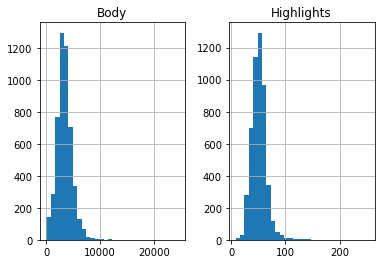

In [10]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_body']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlights']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Body':text_word_count, 'Highlights':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [11]:
max_len_body = 1000
max_len_highlight = 50

In [12]:
data.cleaned_body = data.cleaned_body.progress_apply(lambda x: str(x))
data.cleaned_highlights = data.cleaned_highlights.progress_apply(lambda x: str(x))

100%|██████████| 5000/5000 [00:00<00:00, 1122912.83it/s]


In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data['cleaned_body'],data['cleaned_highlights'],test_size=0.2,random_state=0,shuffle=True)

In [14]:
#A Colab pro environment should have >20Gb of total memory.
from psutil import virtual_memory
colab_pro = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(colab_pro))

if colab_pro < 20:
  print('Not using a high-RAM runtime')
  # train model with lower settings
else:
  print('You are using a high-RAM runtime!')
  # train model with higher settings

Your runtime has 404.0 gigabytes of available RAM

You are using a high-RAM runtime!


In [15]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
import torch

In [16]:
class PegasusDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels['input_ids'])  # len(self.labels)


def prepare_data(model_name,
                 train_texts, train_labels,
                 val_texts=None, val_labels=None,
                 test_texts=None, test_labels=None):
  """
  Prepare input data for model fine-tuning
  """
  tokenizer = PegasusTokenizer.from_pretrained(model_name)

  prepare_val = False if val_texts is None or val_labels is None else True
  prepare_test = False if test_texts is None or test_labels is None else True

  def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True)
    decodings = tokenizer(labels, truncation=True, padding=True)
    dataset_tokenized = PegasusDataset(encodings, decodings)
    return dataset_tokenized

  train_dataset = tokenize_data(train_texts, train_labels)
  val_dataset = tokenize_data(val_texts, val_labels) if prepare_val else None
  test_dataset = tokenize_data(test_texts, test_labels) if prepare_test else None

  return train_dataset, val_dataset, test_dataset, tokenizer
def prepare_fine_tuning(model_name, tokenizer, train_dataset, val_dataset=None, freeze_encoder=False, output_dir='./results'):
  """
  Prepare configurations and base model for fine-tuning
  """
  torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

  if freeze_encoder:
    for param in model.model.encoder.parameters():
      param.requires_grad = False

  if val_dataset is not None:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      num_train_epochs=20,           # total number of training epochs
      per_device_train_batch_size=1,   # batch size per device during training, can increase if memory allows
      per_device_eval_batch_size=1,    # batch size for evaluation, can increase if memory allows
      save_steps=100,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      evaluation_strategy='steps',     # evaluation strategy to adopt during training
      eval_steps=100,                  # number of update steps before evaluation
      warmup_steps=200,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=10,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=val_dataset,            # evaluation dataset
      tokenizer=tokenizer
    )

  else:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      num_train_epochs=5,           # total number of training epochs
      per_device_train_batch_size=1,   # batch size per device during training, can increase if memory allows
      save_steps=100,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      warmup_steps=100,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=50,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      tokenizer=tokenizer
    )

  return trainer

In [17]:
x_train=list(x_train)
x_train[5]
y_train=list(y_train)
y_train[5]

'_START_ a model for evaluating critical success strategies of an erp project with threelevel objectives. three optimization models for setting the optimal management priority for implementing csss. objectivesoriented management of csss by integrating individual departments preferences. a management matrix as a strategic map for effective management of csss. an empirical study with managerial insights and implications. _END_'

In [18]:
model_name = 'google/pegasus-xsum'
train_dataset, _, _, tokenizer = prepare_data(model_name, x_train, y_train)

In [19]:
  # use Pegasus Large model as base for fine-tuning
trainer = prepare_fine_tuning(model_name, tokenizer, train_dataset)
trainer.train()

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
50,10.328700
100,9.518300
150,8.736300
200,7.328600
250,3.694600
300,1.126300
350,0.930200
400,0.758100
450,0.740200
500,0.775500


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-

TrainOutput(global_step=20000, training_loss=0.61444270362854, metrics={'train_runtime': 7428.982, 'train_samples_per_second': 2.692, 'train_steps_per_second': 2.692, 'total_flos': 2.889464414208e+16, 'train_loss': 0.61444270362854, 'epoch': 5.0})

In [20]:
x_test=x_test.tolist()
y_test=y_test.tolist()

In [21]:
test_dataset, _, _, tokenizer = prepare_data(model_name, x_test, y_test)
trainer.evaluate(test_dataset)

{'eval_loss': 0.9355842471122742,
 'eval_runtime': 36.8083,
 'eval_samples_per_second': 27.168,
 'eval_steps_per_second': 3.396,
 'epoch': 5.0}

In [22]:
x_test=list(x_test)
y_test=list(y_test)

In [24]:
import transformers
torch_device =  'cpu'
model = transformers.PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
reference = []
hypothesis = []
for i in range(len(x_test)):
  z=x_test[i]
  z=z[0:2000]
  inputs = tokenizer(z, max_length=10000000000,truncation=True, return_tensors="pt")
  summary_ids = model.generate(inputs["input_ids"])
  y=tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
  hypothesis.append(y)
  z=y_train[i]
  reference.append(z)
 

In [31]:
from rouge import Rouge

In [32]:
score = Rouge()

In [33]:
score.get_scores(hypothesis,reference,avg=True)

{'rouge-1': {'r': 0.030617840667304688,
  'p': 0.08529936288695608,
  'f': 0.0439386318829099},
 'rouge-2': {'r': 0.0010009414778822648,
  'p': 0.003908732933732933,
  'f': 0.0015779342585147023},
 'rouge-l': {'r': 0.02863109378921204,
  'p': 0.07988912713028065,
  'f': 0.041070527456420286}}